### Imports

In [1]:
import pathlib
import re
from collections import Counter
import itertools
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import model_selection
from sklearn import cluster
from sklearn import decomposition
from sklearn import manifold
from sklearn import metrics
from sklearn import linear_model

### Load data

In [2]:
data_folder = pathlib.Path("./data")

In [3]:
data = data_folder / "data.csv"
data_year = data_folder / "data_by_year.csv"
data_genres = data_folder / "data_by_genres.csv"
data_artist = data_folder / "data_by_artist.csv"
data_w_genres = data_folder / "data_w_genres.csv"

In [4]:
df_main = pd.read_csv(data)
df_year = pd.read_csv(data_year)
df_genres = pd.read_csv(data_genres)
df_artist = pd.read_csv(data_artist)
df_w_genres = pd.read_csv(data_w_genres)

### Metadata info

In [5]:
print ("columns in main df are: ", ", ".join(df_main.columns), "\n")

columns in main df are:  acousticness, artists, danceability, duration_ms, energy, explicit, id, instrumentalness, key, liveness, loudness, mode, name, popularity, release_date, speechiness, tempo, valence, year 



#### Note: df_w_genres is artist along with genres

# Artist analysis

In [6]:
df_main.loc[:, "artists"] = df_main.loc[:, "artists"].apply(lambda x: 
                                                            [re.sub("[\[\]'\"]", "", artist) for artist in x.split(",")
                                                            ])

<ipython-input-7-0192e7c627db>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


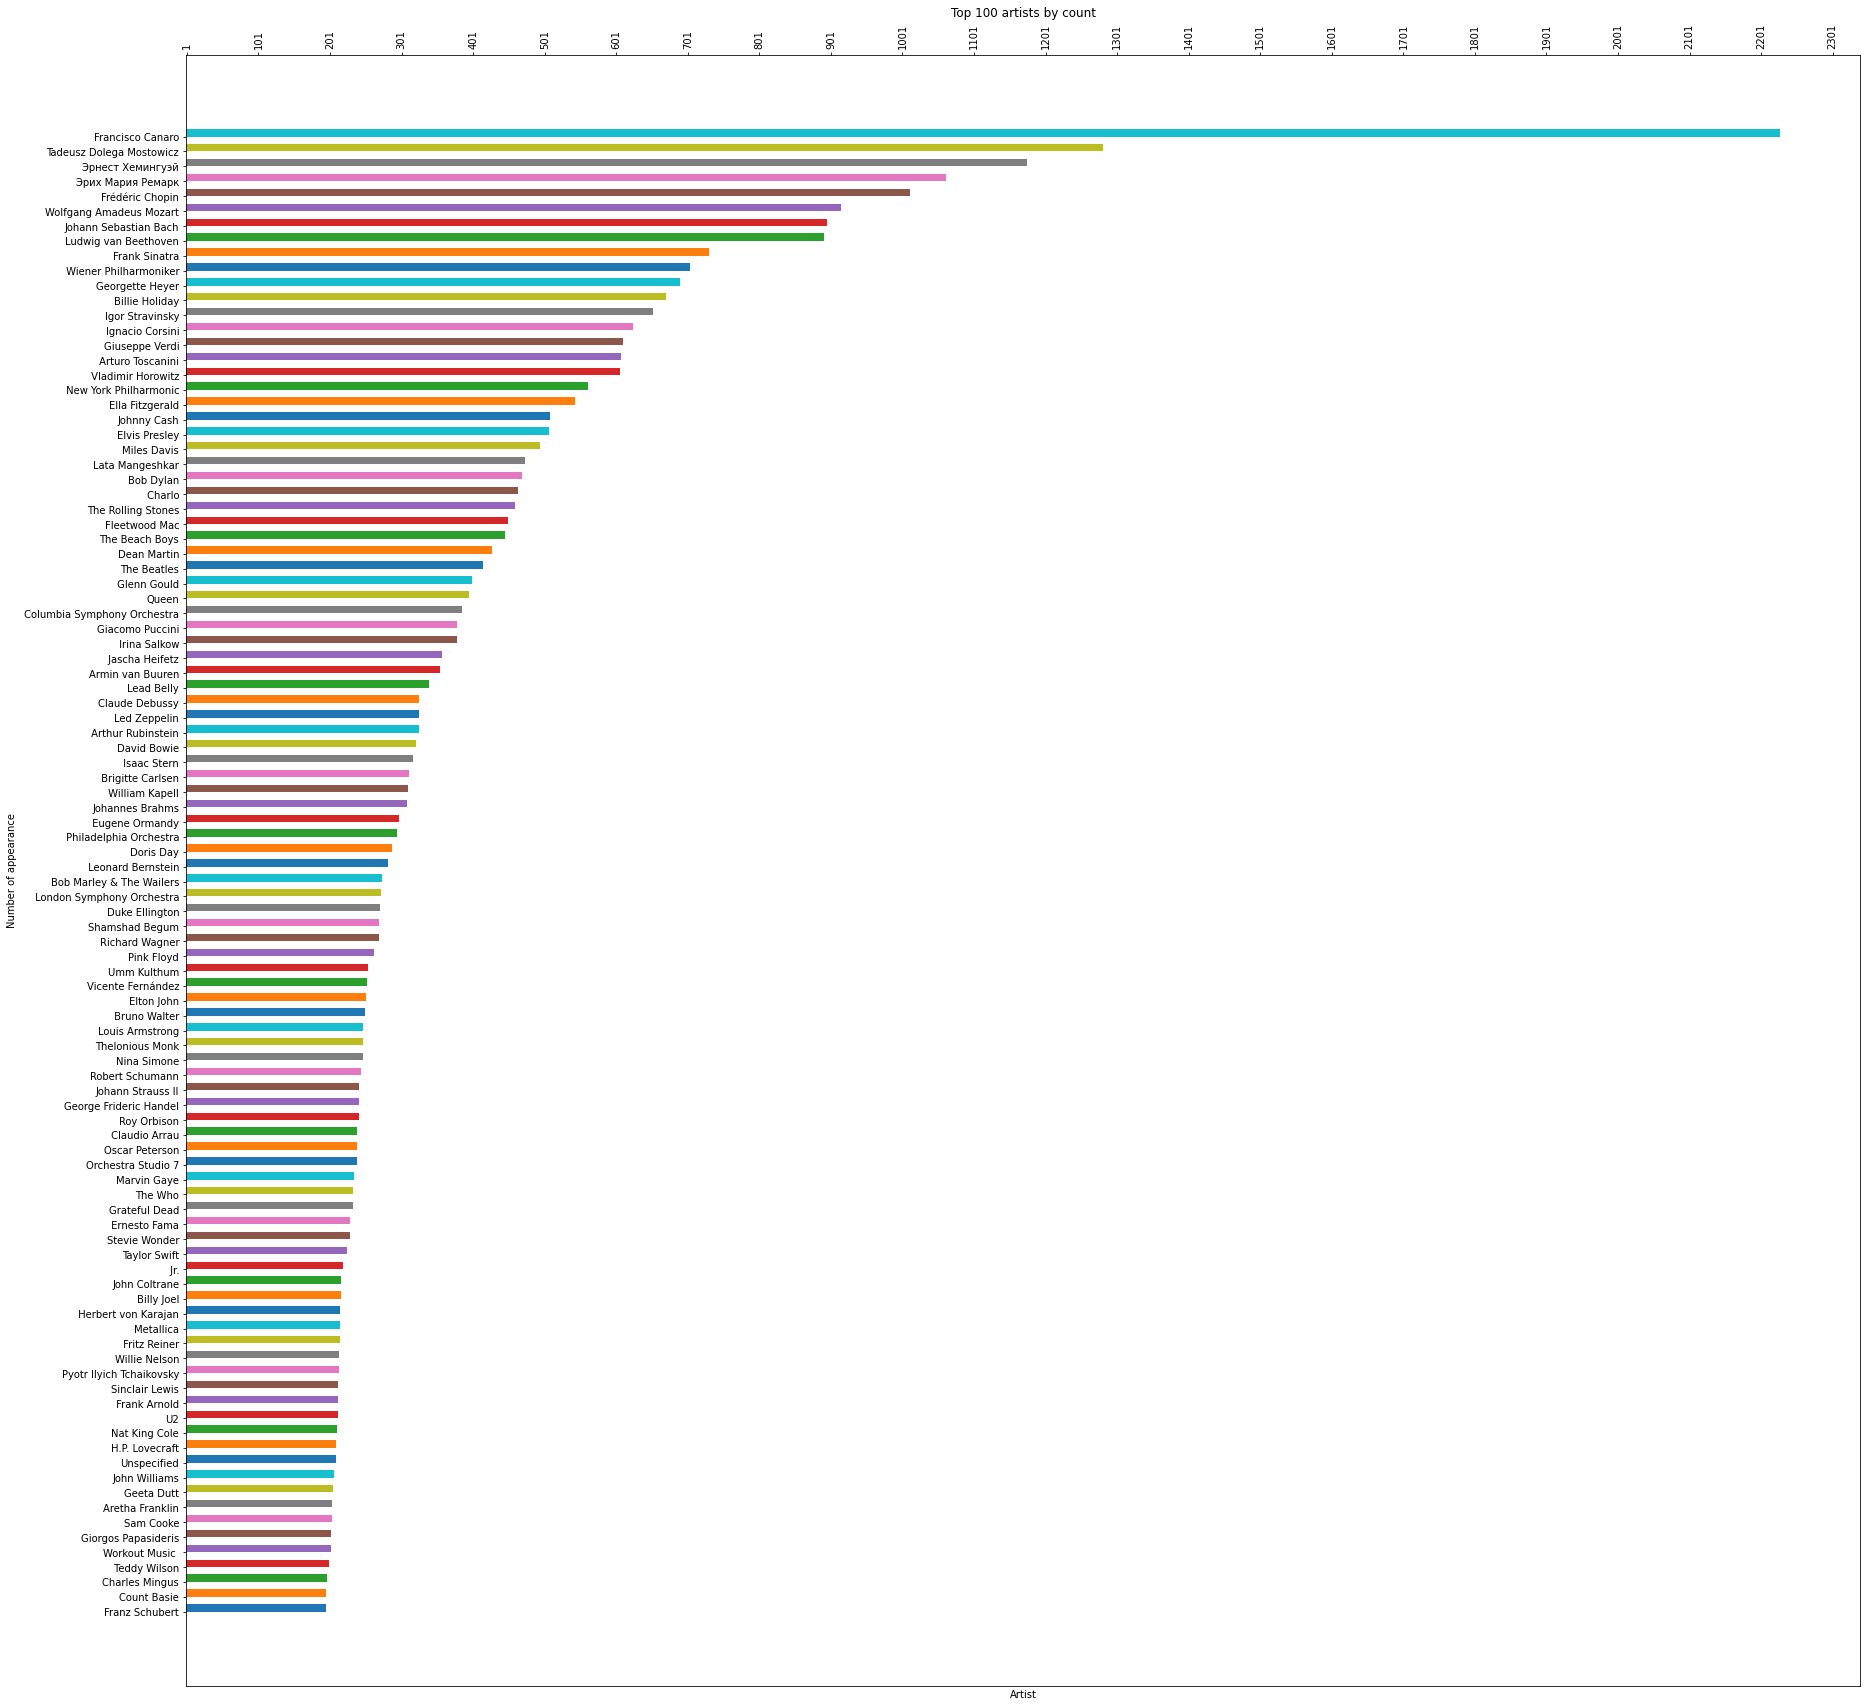

In [7]:
top_k=100
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1,1,1)

top_k_artist = Counter([artist for artists in df_main.loc[:, "artists"].values for artist in artists])
top_k_artist = {artist:count for artist, count in top_k_artist.most_common(top_k)[::-1]}

y_corr = np.linspace(1,top_k, top_k)
x_corr = np.arange(1, max(top_k_artist.values())+100, 100)
color = [f"C{i}" for i in range(top_k)]
ax.barh(y_corr, top_k_artist.values(), 0.5, 0, align="edge", color = color)

ax.set_title(f"Top {top_k} artists by count")
ax.set_xlabel("Artist")
ax.set_ylabel("Number of appearance")


ax.set_yticks(y_corr)
ax.set_xticks(x_corr)

ax.set_yticklabels(top_k_artist.keys())
ax.set_xticklabels(x_corr, rotation = 90)
ax.xaxis.tick_top()

fig.show()

### Find correlation between multiple columns

In [8]:
df_corr = np.abs(df_main.drop("year", axis=1).corr())
for x_idx, y_idx in itertools.product(range(len(df_corr.index)), range(len(df_corr.columns))):
    if x_idx <= y_idx:
        df_corr.loc[df_corr.index[x_idx], df_corr.columns[y_idx]] = 0

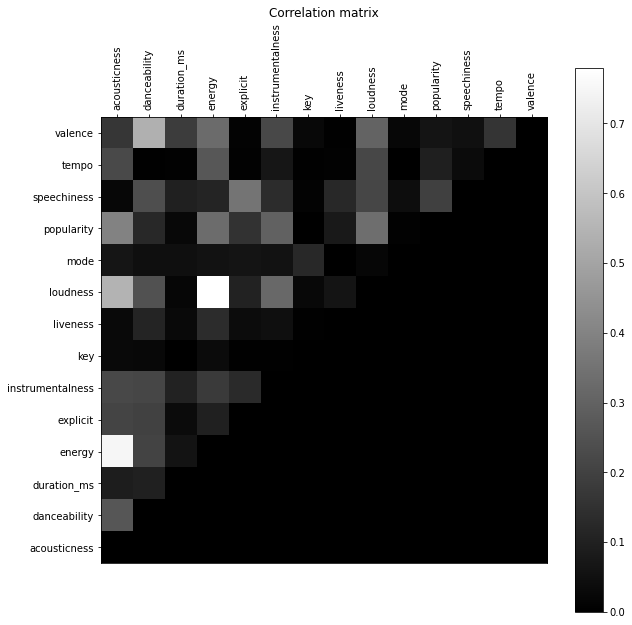

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)


im = ax.imshow(df_corr.values, origin = "lower", cmap="gray")


ax.set_xticks(np.arange(0, len(df_corr.columns), 1))
ax.set_yticks(np.arange(0, len(df_corr.columns), 1))

ax.set_xticklabels(df_corr.columns, rotation=90)
ax.set_yticklabels(df_corr.columns, rotation=0)
ax.xaxis.tick_top()

ax.set_title("Correlation matrix")
fig.colorbar(im, ax=ax)

In [10]:
cols_drop = ['artists', 'name', 'year', 'release_date', 'key', 'id', 'mode', "duration_ms"]
df = df_main.drop(cols_drop, axis=1)

In [11]:
df.describe()

,acousticness,danceability,energy,explicit,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence
count,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000
mean,0.499228,0.536758,0.482721,0.068135,0.197252,0.211123,-11.750865,25.693381,0.105729,117.006500,0.524533
std,0.379936,0.176025,0.272685,0.251978,0.334574,0.180493,5.691591,21.872740,0.182260,30.254178,0.264477
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.087700,0.414000,0.249000,0.000000,0.000000,0.099200,-14.908000,1.000000,0.035200,93.931000,0.311000
50%,0.517000,0.548000,0.465000,0.000000,0.000524,0.138000,-10.836000,25.000000,0.045500,115.816000,0.536000
75%,0.895000,0.669000,0.711000,0.000000,0.252000,0.270000,-7.499000,42.000000,0.076300,135.011000,0.743000
max,0.996000,0.988000,1.000000,1.000000,1.000000,1.000000,3.855000,100.000000,0.971000,243.507000,1.000000


In [12]:
kmeans = cluster.KMeans(n_clusters=3, random_state=0).fit(df.values)

In [13]:
tsne = manifold.TSNE(n_components = 2)
tsne.fit(df.values)

TSNE()

In [14]:
clusters = kmeans.predict(df.values)
coors = tsne.embedding_

### Plot clusters

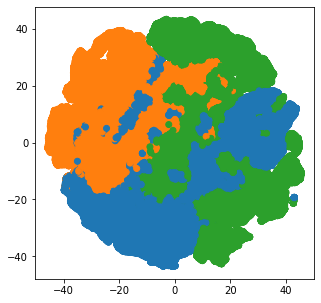

In [15]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

x_coor, y_coor = coors[:, 0], coors[:, 1]

colours = [f"C{cluster}" for cluster in clusters]
labels = [f"cluster_{cluster}" for cluster in clusters]
scatter = ax.scatter(x_coor, y_coor, color=colours)

The clusters are visible in the plot, after projecting the data in 2d using tsne manifolds.

### Predicting popularity of a song. Using simple linear regression

Populairty is quantified using a number between one to hundred in data

In [16]:
df_train, df_test = model_selection.train_test_split(df, train_size=0.7)

In [17]:
x_train, y_train = df_train.drop("popularity", axis=1).values, df_train.loc[:, "popularity"]
x_test, y_test = df_test.drop("popularity", axis=1).values, df_test.loc[:, "popularity"]

### Train the regressor

In [18]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

### Make predictions and evaluate

In [19]:
y_pred = reg.predict(x_test)
error = metrics.mean_squared_error(y_test, y_pred, squared=False)
print(f"Root mean squred error for regressor is: {error}")

Root mean squred error for regressor is: 18.44076009167305
